In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree

time_conv = 977.79222167

In [2]:
t = h5.File('/n/home01/abeane/starbar/plots/torques/data/torques_Nbody-lvl3.hdf5', mode='r')

In [3]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody', 'phantom-vacuum-Sg20-Rc3.5']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
# sn0_list = []
# sn2_list = []
# sn3_list = []
# sn4_list = []
sn5_list = []
sn6_list = []
sn6i_list = []
idx_list = np.arange(0, 1600, 50)
fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
parttype=2
for idx in tqdm(idx_list):
#     sn0 = read_snap(idx, 0, parttype=None, fields=None)
#     sn0_list.append(sn0)
    
#     sn2 = read_snap(idx, 2, parttype=None, fields=None)
#     sn2_list.append(sn2)
    
#     sn3 = read_snap(idx, 3, parttype=None, fields=None)
#     sn3_list.append(sn3)
    
#     sn4 = read_snap(idx, 4, parttype=None, fields=None)
#     sn4_list.append(sn4)

    sn5 = read_snap(idx, 5, parttype=parttype, fields=fields)
    sn5_list.append(sn5)

#     try:
#         sn6 = read_snap(idx, 6, parttype=None, fields=fields)
#         sn6_list.append(sn6)
#     except:
#         pass

#     try:
#         sn6i = read_snap(idx, 6, lvl='lvl3-isotherm', parttype=None, fields=None)
#         sn6i_list.append(sn6i)
#     except:
#         pass



A Jupyter Widget

In [5]:
def get_cyl(sn, pt, center=np.array([200, 200, 200])):
    part = getattr(sn, 'part'+str(pt))
    pos = part.pos.value - center
    vel = part.vel.value
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    z = pos[:,2]
    
    cosphi = pos[:,0]/R
    sinphi = pos[:,1]/R
    
    vR = cosphi * vel[:,0] + sinphi * vel[:,1]
    vphi = cosphi * vel[:,1] - sinphi * vel[:,0]
    vz = vel[:,2]
    
    return np.transpose([R, phi, z, vR, vphi, vz])

In [6]:
bar_Lz = 400
center = np.array([0., 0., 0.])

tz_halo = []
tz_bar = []
tz_disk = []
tz_bulge = []
time_list = []

for i,idx in enumerate(tqdm(idx_list)):
    key = 'snapshot_'+"{:03d}".format(idx)
    sn = sn5_list[i]
    cyl = get_cyl(sn, 2, center=center)
    
    R = cyl[:,0]
    vphi = cyl[:,4]
    
    bar_key = R * vphi < bar_Lz
    disk_key = np.logical_not(bar_key)
    
    bar_pos = (sn.part2.pos.value - center)[bar_key]
    
    acc = t[key]
    #acc_gas = acc['acc_gas']
    acc_halo = acc['acc_halo']
    acc_bar = acc['acc_bar']
    acc_disk = acc['acc_disk']
    acc_bulge = acc['acc_bulge']
    
    torque_halo = np.cross(bar_pos, acc_halo)
    torque_bar = np.cross(bar_pos, acc_bar)
    torque_disk = np.cross(bar_pos, acc_disk)
    torque_bulge = np.cross(bar_pos, acc_bulge)
    
    tz_halo.append(np.sum(torque_halo[:,2]))
    tz_bar.append(np.sum(torque_bar[:,2]))
    tz_disk.append(np.sum(torque_disk[:,2]))
    tz_bulge.append(np.sum(torque_bulge[:,2]))
    
time_list = np.array(t['time'])

tz_halo = np.array(tz_halo)
tz_bar = np.array(tz_bar)
tz_disk = np.array(tz_disk)
tz_bulge = np.array(tz_bulge)
    

A Jupyter Widget

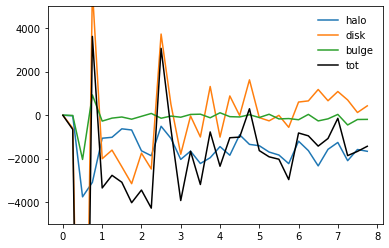

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(time_list[:32], tz_halo, label='halo')
# ax.plot(time_list[:32], tz_bar, label='bar')
ax.plot(time_list[:32], tz_disk, label='disk')
ax.plot(time_list[:32], tz_bulge, label='bulge')
ax.plot(time_list[:32], tz_halo + tz_bar + tz_disk + tz_bulge, label='tot', c='k')

ax.legend(frameon=False)

ax.set(ylim=(-5000, 5000))

plt.show()